In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import pandas as pd

import random
import math
import time

In [2]:
df = pd.read_csv("../../data/raw/title-generation/train.csv")
df.head()

,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...


In [3]:
df.shape

(135000, 2)

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
spacy_en = spacy.load('en_core_web_sm')

In [6]:
def tokenize(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text) if not tok.text.isspace()]

In [7]:
df["abstract"].loc[0]

'we consider the problem of utility maximization for investors with power utility functions. building on the earlier work larsen et al. (2016), we prove that the value of the problem is a frechet-differentiable function of the drift of the price process, provided that this drift lies in a suitable banach space.   we then study optimal investment problems with non-markovian driving processes. in such models there is no hope to get a formula for the achievable maximal utility. applying results of the first part of the paper we provide first order expansions for certain problems involving fractional brownian motion either in the drift or in the volatility. we also point out how asymptotic results can be derived for models with strong mean reversion.'

In [8]:
tokenize(df["abstract"].loc[0])

['we',
 'consider',
 'the',
 'problem',
 'of',
 'utility',
 'maximization',
 'for',
 'investors',
 'with',
 'power',
 'utility',
 'functions',
 '.',
 'building',
 'on',
 'the',
 'earlier',
 'work',
 'larsen',
 'et',
 'al',
 '.',
 '(',
 '2016',
 ')',
 ',',
 'we',
 'prove',
 'that',
 'the',
 'value',
 'of',
 'the',
 'problem',
 'is',
 'a',
 'frechet',
 '-',
 'differentiable',
 'function',
 'of',
 'the',
 'drift',
 'of',
 'the',
 'price',
 'process',
 ',',
 'provided',
 'that',
 'this',
 'drift',
 'lies',
 'in',
 'a',
 'suitable',
 'banach',
 'space',
 '.',
 'we',
 'then',
 'study',
 'optimal',
 'investment',
 'problems',
 'with',
 'non',
 '-',
 'markovian',
 'driving',
 'processes',
 '.',
 'in',
 'such',
 'models',
 'there',
 'is',
 'no',
 'hope',
 'to',
 'get',
 'a',
 'formula',
 'for',
 'the',
 'achievable',
 'maximal',
 'utility',
 '.',
 'applying',
 'results',
 'of',
 'the',
 'first',
 'part',
 'of',
 'the',
 'paper',
 'we',
 'provide',
 'first',
 'order',
 'expansions',
 'for',
 'ce

In [9]:
from torchtext.data import Field, BucketIterator
from torchtext import data
from torchtext import vocab

In [10]:
TEXT = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            include_lengths = True,
            lower = True)

In [11]:
trn_data_fields = [("src", TEXT),
                   ("trg", TEXT)]

dataset = data.TabularDataset(
    path='../../data/raw/title-generation/train.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [12]:
# trainds, valds = data.TabularDataset.splits(
#     path='./data', 
#     format='csv', 
#     train='traindf.csv', 
#     validation='valdf.csv', 
#     fields=train_val_fields, 
#     skip_header=True
# )

In [13]:
type(train_data)

torchtext.data.dataset.Dataset

In [14]:
len(train_data), len(valid_data), len(test_data)

(132300, 1350, 1350)

In [15]:
train_data.fields.items()

dict_items([('src', <torchtext.data.field.Field object at 0x7f9c8f1beb38>), ('trg', <torchtext.data.field.Field object at 0x7f9c8f1beb38>)])

In [16]:
ex = train_data[0]
type(ex)

torchtext.data.example.Example

In [17]:
ex.src

['we',
 'quantify',
 'the',
 'contributions',
 'of',
 'hyperfine',
 'and',
 'spin',
 '-',
 'orbit',
 'mediated',
 'singlet',
 '-',
 'triplet',
 'mixing',
 'in',
 'weakly',
 'coupled',
 'inas',
 'quantum',
 'dots',
 'by',
 'electron',
 'transport',
 'spectroscopy',
 'in',
 'the',
 'pauli',
 'spin',
 'blockade',
 'regime',
 '.',
 'in',
 'contrast',
 'to',
 'double',
 'dots',
 'in',
 'gaas',
 ',',
 'the',
 'spin',
 '-',
 'orbit',
 'coupling',
 'is',
 'found',
 'to',
 'be',
 'more',
 'than',
 'two',
 'orders',
 'of',
 'magnitudes',
 'larger',
 'than',
 'the',
 'hyperfine',
 'mixing',
 'energy',
 '.',
 'it',
 'is',
 'already',
 'effective',
 'at',
 'magnetic',
 'fields',
 'of',
 'a',
 'few',
 'mt',
 ',',
 'where',
 'deviations',
 'from',
 'hyperfine',
 'mixing',
 'are',
 'observed',
 '.']

In [18]:
ex.trg

['spin', 'state', 'mixing', 'in', 'inas', 'double', 'quantum', 'dots']

In [19]:
TEXT.build_vocab(train_data, min_freq = 7)
print(f"Unique tokens in vocabulary: {len(TEXT.vocab)}")

Unique tokens in vocabulary: 40501


In [20]:
# python -m gensim.downloader --download glove-wiki-gigaword-300

In [21]:
vec = vocab.Vectors('/home/science/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz')

In [22]:
TEXT.build_vocab(train_data, valid_data, test_data, vectors=vec, min_freq = 7)

In [23]:
print(f"Unique tokens in vocabulary: {len(TEXT.vocab)}")

Unique tokens in vocabulary: 40938


In [24]:
print(TEXT.vocab.vectors.shape)

torch.Size([40938, 300])


In [25]:
TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

tensor([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8

In [26]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [27]:
device

device(type='cuda')

In [28]:
print(len(train_iterator), len(valid_iterator), len(test_iterator))

2068 22 22


In [29]:
# batch = next(iter(traindl)) # BucketIterator return a batch object
# print(type(batch))
# # torchtext.data.batch.Batch

# print(batch.Sentiment) # labels of the batch
# # tensor([ 0,  0,  0], device='cuda:0')

# print(batch.SentimentText) # text index and length of the batch
# # (tensor([[  204,   107,   956],
# #         [   29,  3176,   112],
# #         [ 4391,   195,    28],
# #         [ 1413,    57,    57],
# #         [   19,    32,    26],
# #         [   32,   114,  5138]], device='cuda:0'),
# # tensor([ 6,  6,  6], device='cuda:0'))

# print(batch.dataset.fields)

In [30]:
batch = next(iter(train_iterator))

In [31]:
print(type(batch))

<class 'torchtext.data.batch.Batch'>


In [32]:
print(batch.src)

(tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [3909,  164,   21,  ...,   21,   13, 1642],
        [3252,  150,   47,  ...,   47,   96,   29],
        ...,
        [ 423,   35,  489,  ...,    6,    6,    6],
        [   6,    6,    6,  ...,    3,    3,    3],
        [   3,    3,    3,  ...,    1,    1,    1]], device='cuda:0'), tensor([143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
        143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
        143, 143, 143, 143, 143, 143, 143, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142], device='cuda:0'))


In [33]:
print(batch.trg)

(tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [3252,  127,  790,  ...,  343,    9,    9],
        [  25,  280,  342,  ..., 1294,  553,   59],
        ...,
        [   1,    1,    1,  ...,    1,  547,    1],
        [   1,    1,    1,  ...,    1,  503,    1],
        [   1,    1,    1,  ...,    1,    3,    1]], device='cuda:0'), tensor([13, 11, 10, 15, 11, 14,  8,  8, 14, 18, 15, 12, 16,  6, 17,  7, 12,  9,
        11, 17,  9, 12,  9, 18, 12, 16,  8, 16, 17, 11, 11, 15, 15, 15, 14, 13,
        12, 14,  8, 10, 14,  8, 15, 13,  8,  9, 17,  5, 17, 11,  9, 14, 13, 11,
        16, 15, 19, 10, 13, 11, 16, 11, 20, 10], device='cuda:0'))


In [34]:
print(batch.dataset.fields)

{'src': <torchtext.data.field.Field object at 0x7f9c8f1beb38>, 'trg': <torchtext.data.field.Field object at 0x7f9c8f1beb38>}


In [35]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [36]:
train_batch_it = BatchGenerator(train_iterator, 'src', 'trg')

In [37]:
print(next(iter(train_batch_it)))

((tensor([[    2,     2,     2,  ...,     2,     2,     2],
        [ 5015,  4303,    11,  ...,    13,    13,   123],
        [ 4914,  3113,    21,  ...,    96,   329,     9],
        ...,
        [38743,     6,     6,  ...,     3,     3,     3],
        [    6,     3,     3,  ...,     1,     1,     1],
        [    3,     1,     1,  ...,     1,     1,     1]], device='cuda:0'), tensor([112, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
        111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
        111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 110, 110, 110,
        110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
        110, 110, 110, 110, 110, 110, 110, 110], device='cuda:0')), (tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,  215,   54,  ...,  179, 3869, 1037],
        [8501,  132,   10,  ...,  193, 1119,  166],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,  

In [38]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [39]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [40]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

In [41]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            # and mask
            #receive output tensor (predictions), new hidden state and attention tensor
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #place attentions in a tensor holding attention value for each input token
            attentions[t] = attention
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
            #if doing inference and next token/prediction is an eos token then stop
            if inference and input.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

In [42]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi['<pad>']
SOS_IDX = TEXT.vocab.stoi['<sos>']
EOS_IDX = TEXT.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)



In [43]:
INPUT_DIM

40938

In [44]:
PAD_IDX, SOS_IDX, EOS_IDX

(1, 2, 3)

In [45]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


In [46]:
model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(40938, 300)
    (rnn): GRU(300, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=64, bias=True)
    )
    (embedding): Embedding(40938, 300)
    (rnn): GRU(428, 64)
    (out): Linear(in_features=492, out_features=40938, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
)

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 45,001,298 trainable parameters


In [48]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [49]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg, trg_len = batch.trg
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

In [50]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg, trg_len = batch.trg

            output, attention = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

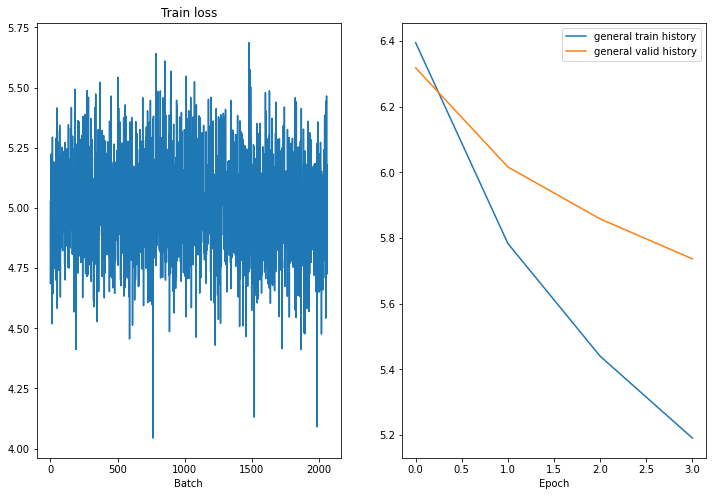

Epoch: 05 | Time: 14m 30s
	Train Loss: 5.009 | Train PPL: 149.700
	 Val. Loss: 5.656 |  Val. PPL: 285.912


In [52]:
MODEL_NAME = 'models/lstm_baseline.pt'
N_EPOCHS = 5
CLIP = 1

train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [53]:
# for cpu usage
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')))

# for gpu usage
# model.load_state_dict(torch.load(MODEL_NAME), map_location=torch.device('cpu'))


test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.714 | Test PPL: 302.992 |


In [54]:
def translate_sentence(model, tokenized_sentence):
    model.eval()
    tokenized_sentence = ['<sos>'] + [t.lower() for t in tokenized_sentence] + ['<eos>']
    numericalized = [TEXT.vocab.stoi[t] for t in tokenized_sentence] 
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TEXT.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

In [55]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(30,50))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy().T
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=12)
    ax.set_yticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'])
    ax.set_xticklabels(['']+translation, rotation=80)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [56]:
example_idx = 100

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['the', 'integrated', 'completed', 'likelihood', '(', 'icl', ')', 'criterion', 'has', 'proven', 'to', 'be', 'a', 'very', 'popular', 'approach', 'in', 'model', '-', 'based', 'clustering', 'through', 'automatically', 'choosing', 'the', 'number', 'of', 'clusters', 'in', 'a', 'mixture', 'model', '.', 'this', 'approach', 'effectively', 'maximises', 'the', 'complete', 'data', 'likelihood', ',', 'thereby', 'including', 'the', 'allocation', 'of', 'observations', 'to', 'clusters', 'in', 'the', 'model', 'selection', 'criterion', '.', 'however', 'for', 'practical', 'implementation', 'one', 'needs', 'to', 'introduce', 'an', 'approximation', 'in', 'order', 'to', 'estimate', 'the', 'icl', '.', 'our', 'contribution', 'here', 'is', 'to', 'illustrate', 'that', 'through', 'the', 'use', 'of', 'conjugate', 'priors', 'one', 'can', 'derive', 'an', 'exact', 'expression', 'for', 'icl', 'and', 'so', 'avoiding', 'any', 'approximation', '.', 'moreover', ',', 'we', 'illustrate', 'how', 'one', 'can', 'find',

In [57]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'model', 'for', 'for', 'mixture', 'models']


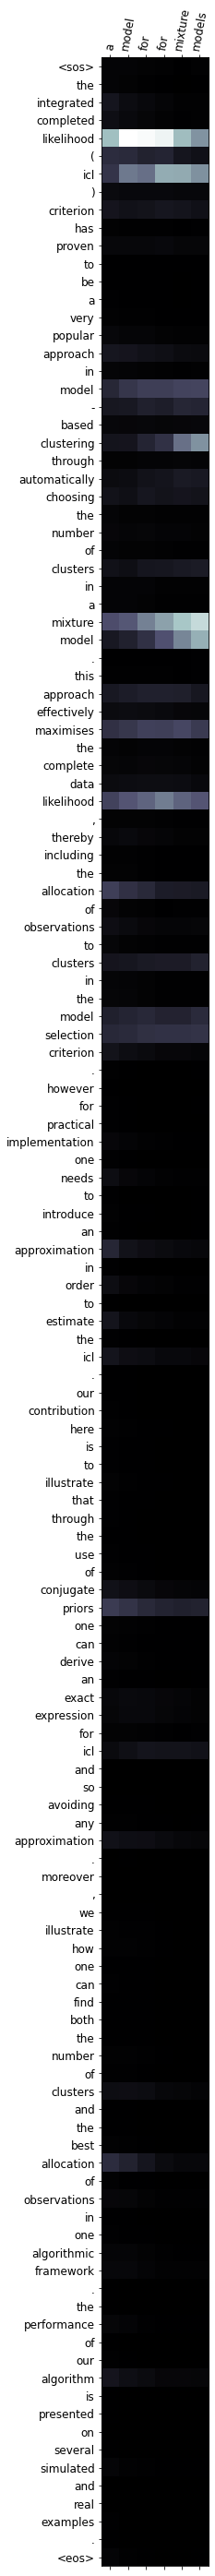

In [58]:
display_attention(src, translation, attention)

In [59]:
for example_idx in range(100):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(model, src)

    print('Оригинальный заголовок: ', ' '.join(trg))
    print('Предсказанный заголовок: ', ' '.join(translation))
    print('-----------------------------------')

Оригинальный заголовок:  diversity and its decomposition into variety , balance and disparity
Предсказанный заголовок:  a of of of
-----------------------------------
Оригинальный заголовок:  improving the johnson - lindenstrauss lemma
Предсказанный заголовок:  on the of of - - -
-----------------------------------
Оригинальный заголовок:  the mean - field approximation model of company 's income growth
Предсказанный заголовок:  the of income distribution of income income distribution
-----------------------------------
Оригинальный заголовок:  efficient inference of protein structural ensembles
Предсказанный заголовок:  protein - of protein folding
-----------------------------------
Оригинальный заголовок:  financial black swans driven by ultrafast machine ecology
Предсказанный заголовок:  the of of of of of of the
-----------------------------------
Оригинальный заголовок:  tracking dynamic point processes on networks
Предсказанный заголовок:  a temporal structure of temporal networ

In [60]:
example_idx = 0

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['suppose', 'a', 'string', '$', 'x_1^n=(x_1,x_2,', '...', ',x_n)$', 'generated', 'by', 'a', 'memoryless', 'source', '$', '(', 'x_n)_{n\\geq', '1}$', 'with', 'distribution', '$', 'p$', 'is', 'to', 'be', 'compressed', 'with', 'distortion', 'no', 'greater', 'than', '$', 'd\\geq', '0', '$', ',', 'using', 'a', 'memoryless', 'random', 'codebook', 'with', 'distribution', '$', 'q$.', 'the', 'compression', 'performance', 'is', 'determined', 'by', 'the', '`', '`', 'generalized', 'asymptotic', 'equipartition', 'property', "'", "'", '(', 'aep', ')', ',', 'which', 'states', 'that', 'the', 'probability', 'of', 'finding', 'a', '$', 'd$-close', 'match', 'between', '$', 'x_1^n$', 'and', 'any', 'given', 'codeword', '$', 'y_1^n$', ',', 'is', 'approximately', '$', '2^{-n', 'r(p', ',', 'q', ',', 'd)}$', ',', 'where', 'the', 'rate', 'function', '$', 'r(p', ',', 'q', ',', 'd)$', 'can', 'be', 'expressed', 'as', 'an', 'infimum', 'of', 'relative', 'entropies', '.', 'the', 'main', 'purpose', 'here', 'is', 

predicted trg = ['a', 'of', 'of', 'of', 'the', 'of', 'of', 'the']


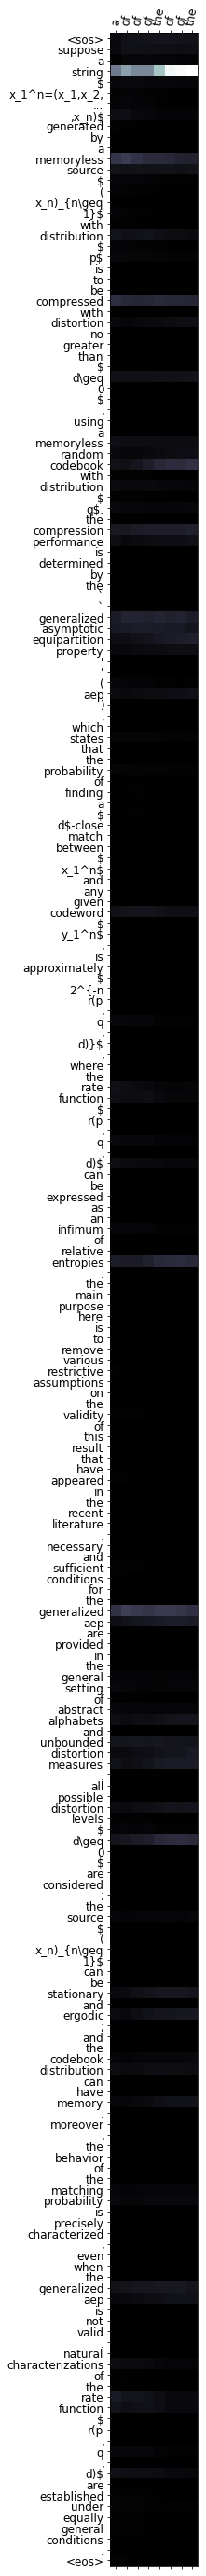

In [61]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [62]:
example_idx = 510

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['we', 'present', 'a', 'bayesian', 'hierarchical', 'framework', 'for', 'both', 'cross', '-', 'sectional', 'and', 'time', '-', 'series', 'return', 'prediction', '.', 'our', 'approach', 'builds', 'on', 'a', 'market', '-', 'timing', 'predictive', 'system', 'that', 'jointly', 'allows', 'for', 'time', '-', 'varying', 'coefficients', 'driven', 'by', 'fundamental', 'characteristics', '.', 'with', 'a', 'bayesian', 'formulation', 'for', 'ensemble', 'learning', ',', 'we', 'examine', 'the', 'joint', 'predictability', 'as', 'well', 'as', 'portfolio', 'efficiency', 'via', 'predictive', 'distribution', '.', 'in', 'the', 'empirical', 'analysis', 'of', 'asset', '-', 'sector', 'allocation', ',', 'our', 'hierarchical', 'ensemble', 'learning', 'portfolio', 'achieves', '500', '%', 'cumulative', 'returns', 'in', 'the', 'period', '1998', '-', '2017', ',', 'and', 'outperforms', 'most', 'workhorse', 'benchmarks', 'as', 'well', 'as', 'the', 'passive', 'investing', 'index', '.', 'our', 'bayesian', 'infere

predicted trg = ['bayesian', 'bayesian', 'bayesian', 'for', 'bayesian', '-', '-']


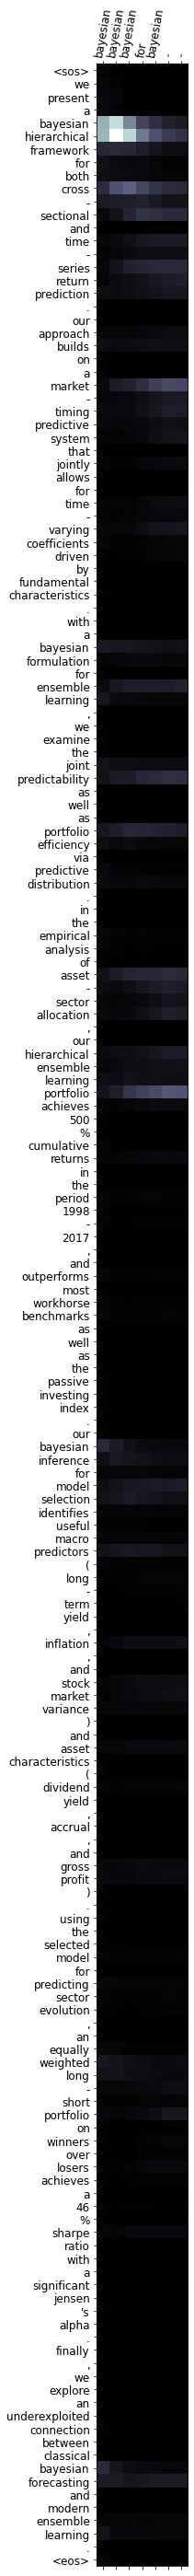

In [63]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### Считаем BLEU на train.csv

In [64]:
import nltk

n_gram_weights = [0.3334, 0.3333, 0.3333]

In [65]:
test_len = len(test_data)

In [66]:
original_texts = []
generated_texts = []
macro_bleu = 0

for example_idx in range(test_len):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, _ = translate_sentence(model, src)

    original_texts.append(trg)
    generated_texts.append(translation)

    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        [trg],
        translation,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score

macro_bleu /= test_len

/home/science/projects/simcube/venv/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/science/projects/simcube/venv/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [67]:
# averaging sentence-level BLEU (i.e. macro-average precision)
print('Macro-average BLEU (LSTM): {0:.5f}'.format(macro_bleu))

Macro-average BLEU (LSTM): 0.00968


### Делаем submission в Kaggle

In [69]:
import pandas as pd

submission_data = pd.read_csv('../../data/raw/title-generation/test.csv')
abstracts = submission_data['abstract'].values

Генерация заголовков для тестовых данных:

In [70]:
titles = []
for abstract in abstracts:
    title, _ = translate_sentence(model, abstract.split())
    titles.append(' '.join(title).replace('<unk>', ''))

Записываем полученные заголовки в файл формата `<abstract>,<title>`:

In [72]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

С помощью скрипта `generate_csv` приводим файл `submission_prediction.csv` в формат, необходимый для посылки в соревнование на Kaggle:

In [77]:
import pickle
with open('vocs.pkl', 'wb') as f:
    pickle.dump(TEXT.vocab.vectors, f)

In [79]:
from create_submission import generate_csv

generate_csv('predicted_titles.csv', 'kaggle_pred.csv', 'vocs.pkl')